In [1]:
import numpy as np
import pandas as pd
import ee
import requests
import os
import geopandas as gpd
# Initialize the Earth Engine API
ee.Initialize(project='ts-rishimnb')


In [2]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
print(bbox)

[78.00405826 16.93264351 79.04971836 17.90150706]


In [3]:
# ee.Initialize()

# # Define the area of interest (AOI) using coordinates
# bbox = ee.Geometry.Rectangle([78.00405826, 16.93264351, 79.04971836, 17.90150706])  # Example coordinates

# # Choose the Sentinel-2 image collection and filter by date and bounds
# image_collection = ee.ImageCollection("MODIS/061/MOD11A1") \
#     .filterBounds(bbox) \
#     .filterDate('2022-03-16', '2022-03-1') \

# img =image_collection.mean()
# # Specify the bands to download (e.g., true color bands B4, B3, B2)
# url = img.getDownloadUrl({
#     'bands': [
#     "LST_Day_1km"],
#     'region': bbox,
#     'scale': 1000,
#     'format': 'GEO_TIFF'
# })
# response = requests.get(url)
# with open('modis_lst.tif', 'wb') as fd:
#   fd.write(response.content)

GeoTIFF Metadata:
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 117, 'height': 109, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.008983152841195215, 0.0, 78.00071612009806,
       0.0, -0.008983152841195215, 17.903423612502063), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


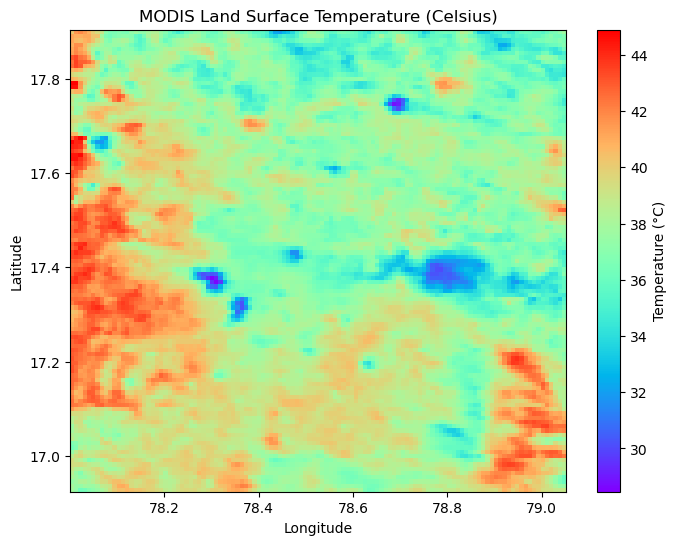

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

geo_tiff_path = 'modis_lst.tif'  
with rasterio.open(geo_tiff_path) as src:
    lst_raw = src.read(1).astype(float)

    # Get metadata
    profile = src.profile
    print("GeoTIFF Metadata:")
    print(profile)

    # Get the affine transformation
    transform = src.transform
    
    # Calculate the extent of the image for plotting
    xmin, ymax = transform * (0, 0)
    xmax, ymin = transform * (lst_raw.shape[1], lst_raw.shape[0])
    extent = [xmin, xmax, ymin, ymax]

lst_kelvin = lst_raw * 0.02 

lst_celsius = lst_kelvin - 273.15
plt.figure(figsize=(8, 6))
plt.imshow(lst_celsius, cmap='rainbow', extent=extent)  
plt.title('MODIS Land Surface Temperature (Celsius)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar()
cbar.set_label('Temperature (°C)')
plt.show()


In [5]:
ee.Initialize()

# Define the area of interest (AOI) using coordinates
bbox = ee.Geometry.Rectangle([78.00405826, 16.93264351, 79.04971836, 17.90150706])  # Example coordinates

# Choose the Sentinel-2 image collection and filter by date and bounds
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(bbox) \
    .filterDate('2021-05-1', '2021-05-31') \

img =image_collection.median()
# Specify the bands to download (e.g., true color bands B4, B3, B2)
url = img.getDownloadUrl({
    'bands': [
    "ST_B10","ST_QA","QA_PIXEL"],
    'region': bbox,
    'scale': 100,
    'format': 'GEO_TIFF'
})
response = requests.get(url)
with open('landsat_lst.tif', 'wb') as fd:
  fd.write(response.content)


In [6]:
def get_landsat(start_date,end_date, file_name,dire):
    bbox = ee.Geometry.Rectangle([78.00405826, 16.93264351, 79.04971836, 17.90150706])
    image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(bbox) \
    .filterDate(start_date,end_date) \

    img =image_collection.mean()
    # Specify the bands to download (e.g., true color bands B4, B3, B2)
    url = img.getDownloadUrl({
        'bands': [
        "ST_B10","ST_QA","QA_PIXEL"],
        'region': bbox,
        'scale': 100,
        'format': 'GEO_TIFF'
    })
    response = requests.get(url)
    file_path=os.path.join(dire,file_name)
    with open(file_path, 'wb') as fd:
        fd.write(response.content)


In [7]:
big_dir=r"C:\Users\rishi\ml_projects\UHI\Landsat_14\LST"
months = {
    1: ("January", 31),
    2: ("February", 28),
    3: ("March", 31),
    4: ("April", 30),
    5: ("May", 31),
    6: ("June", 30),
    7: ("July", 31),
    8: ("August", 31),
    9: ("September", 30),
    10: ("October", 31),
    11: ("November", 30),
    12: ("December", 31)
}
for i in range(1,13):
    file_name=f"{months[i][0]}.tif"
    start_date=f"2014-{i}-1"
    end_date=f"2014-{i}-{months[i][1]}"
    dire=big_dir
    get_landsat(start_date,end_date,file_name,dire)

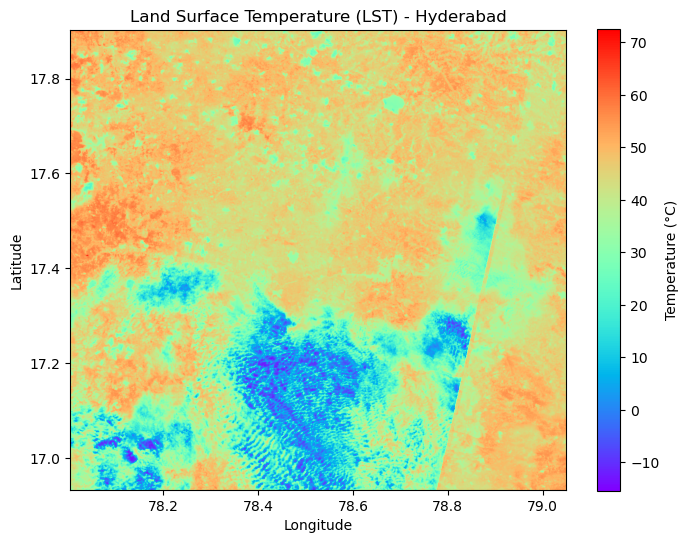

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the GeoTIFF file
geo_tiff_path = 'landsat_lst.tif'  # Replace with your file path

with rasterio.open(geo_tiff_path) as src:
    band10 = src.read(1).astype(float)
    cloud=src.read(3).astype(int)
    unc=src.read(2).astype(float)*.01 # Thermal Band (ST_B10)
    st_meta=src.meta
    # Metadata
    transform = src.transform
    extent = [transform[2], transform[2] + transform[0] * src.width,
              transform[5] + transform[4] * src.height, transform[5]]

    LST_K=band10*0.00341802+149
    LST_C=LST_K-273.15
    plt.figure(figsize=(8, 6))
    plt.imshow(LST_C, cmap='rainbow', extent=extent)  # Hot colormap for temperature
    plt.title("Land Surface Temperature (LST) - Hyderabad")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    cbar = plt.colorbar()
    cbar.set_label("Temperature (°C)")
    plt.show()

In [9]:
st_data=LST_C
st_valid = st_data[~np.isnan(st_data)].flatten()

# Compute the 1st and 99th percentile thresholds
low_thresh = np.percentile(st_valid, 1)  # Bottom 1% threshold
high_thresh = np.percentile(st_valid, 99)  # Top 1% threshold

# Mask out values beyond these thresholds
st_cleaned = np.where((st_data >= low_thresh) & (st_data <= high_thresh), st_data, np.nan)

# Save the cleaned data
st_meta.update(dtype="float32", nodata=np.nan)

with rasterio.open("ST_B10_cleaned.tif", "w", **st_meta) as dst:
    dst.write(st_cleaned.astype(np.float32), 1)

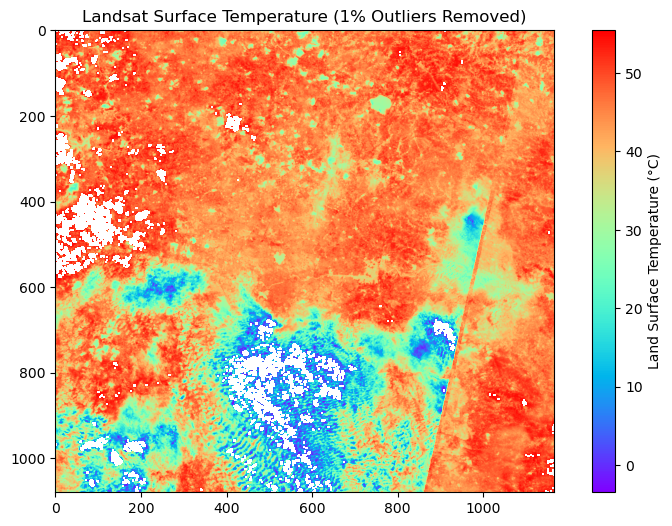

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(st_cleaned, cmap="rainbow")  # Adjust based on your data
plt.colorbar(label="Land Surface Temperature (°C)")
plt.title("Landsat Surface Temperature (1% Outliers Removed)")
plt.show()


In [11]:
cloud

array([[21824, 21824, 21824, ..., 21824, 21824, 21824],
       [21824, 21824, 21824, ..., 21824, 21824, 21824],
       [21824, 21824, 21824, ..., 21824, 21824, 21824],
       ...,
       [22052, 22052, 22052, ..., 21824, 21824, 21824],
       [22052, 22052, 22052, ..., 21824, 21824, 21824],
       [22052, 22052, 22052, ..., 21824, 21824, 21824]])

In [12]:
LST_C

array([[53.26745513, 51.62680553, 50.37922823, ..., 46.92361001,
        47.71659065, 47.7422258 ],
       [54.22962776, 53.89978883, 51.57895325, ..., 47.68241045,
        47.82938531, 47.55765272],
       [55.53702041, 55.47378704, 53.56824089, ..., 46.86208565,
        46.60915217, 45.45044339],
       ...,
       [27.31613828, 28.34325329, 31.73051111, ..., 51.88486604,
        51.82505069, 51.86606693],
       [28.46117498, 29.36353226, 29.18066819, ..., 52.0147508 ,
        51.86606693, 51.20126204],
       [29.38574939, 30.30006974, 29.5925396 , ..., 52.56334301,
        51.63535058, 50.71932122]])

In [13]:
np.nanmean(LST_C)

38.92196880842627

In [14]:
np.shape(LST_C)

(1080, 1165)

In [15]:
np.nanmax(LST_C)

72.53141585000003

In [16]:
print(cloud)

[[21824 21824 21824 ... 21824 21824 21824]
 [21824 21824 21824 ... 21824 21824 21824]
 [21824 21824 21824 ... 21824 21824 21824]
 ...
 [22052 22052 22052 ... 21824 21824 21824]
 [22052 22052 22052 ... 21824 21824 21824]
 [22052 22052 22052 ... 21824 21824 21824]]


In [17]:
lst_c2=LST_C

In [18]:
too_high=0
nan_count=0
for i in range(len(unc)):
    for j in range(len(unc[0])):
        if (cloud[i][j] >> 3)&1 == 1 or unc[i][j]>=6:
            lst_c2[i][j]=np.nan
            nan_count+=1
        if LST_C[i][j]>=55:
            too_high+=1

In [19]:
(22052>>3)&1

0

In [20]:
print(too_high, nan_count)

15749 251992


In [21]:
lst_c2

array([[53.26745513, 51.62680553, 50.37922823, ..., 46.92361001,
        47.71659065, 47.7422258 ],
       [54.22962776, 53.89978883, 51.57895325, ..., 47.68241045,
        47.82938531, 47.55765272],
       [55.53702041, 55.47378704, 53.56824089, ..., 46.86208565,
        46.60915217, 45.45044339],
       ...,
       [27.31613828, 28.34325329, 31.73051111, ..., 51.88486604,
        51.82505069, 51.86606693],
       [28.46117498, 29.36353226, 29.18066819, ..., 52.0147508 ,
        51.86606693, 51.20126204],
       [29.38574939, 30.30006974, 29.5925396 , ..., 52.56334301,
        51.63535058, 50.71932122]])

In [22]:
print(lst_celsius)

[[40.10818182 41.498      41.81363636 ... 36.57       37.17307692
  37.70833333]
 [41.166      40.87545455 40.87       ... 36.34076923 36.27461538
  36.69153846]
 [41.102      40.63727273 40.45666667 ... 36.51769231 36.93153846
  36.60333333]
 ...
 [37.39307692 37.75461538 38.26230769 ... 37.34230769 36.50230769
  36.00846154]
 [37.98076923 37.49461538 37.39923077 ... 38.10230769 37.52076923
  37.40846154]
 [37.84538462 37.33923077 36.22846154 ... 38.91       38.90076923
  38.87923077]]


In [23]:
np.max(lst_celsius)

44.8936363636364

In [24]:
np.min(lst_celsius)

28.460769230769245

In [25]:
np.nanmax(lst_c2)

72.53141585000003

In [26]:
np.nanmin(lst_c2)

6.736239860000012